--- Starting Figure Generation for 16/19 Cultigens ---

Loading Cultivated1st (16 Cultigens) data...
Loading data from ../data/CULTIVATED2ND/03_morphometrics_output_cultivated1st_combined/original_pca_scores_and_class_labels_cultivated1st.h5
Loading PCA parameters from ../data/CULTIVATED2ND/03_morphometrics_output_cultivated1st_combined/leaf_pca_model_parameters_cultivated1st.h5
Data loaded for 

Loading Cultivated2nd (19 Cultigens) data...
Loading data from ../data/CULTIVATED2ND/03_morphometrics_output_cultivated2nd_combined/original_pca_scores_and_class_labels_cultivated2nd.h5
Loading PCA parameters from ../data/CULTIVATED2ND/03_morphometrics_output_cultivated2nd_combined/leaf_pca_model_parameters_cultivated2nd.h5
Data loaded for 
Dynamically calculated HEIGHT_PER_MORPHOSPACE_PANEL_1ST_INCHES: 2.14 inches
Dynamically calculated HEIGHT_PER_MORPHOSPACE_PANEL_2ND_INCHES: 3.66 inches
Resulting FIGURE_HEIGHT_INCHES (with padding): 6.50 inches

Plotting Cultivated1st (16 Cultigens) row...


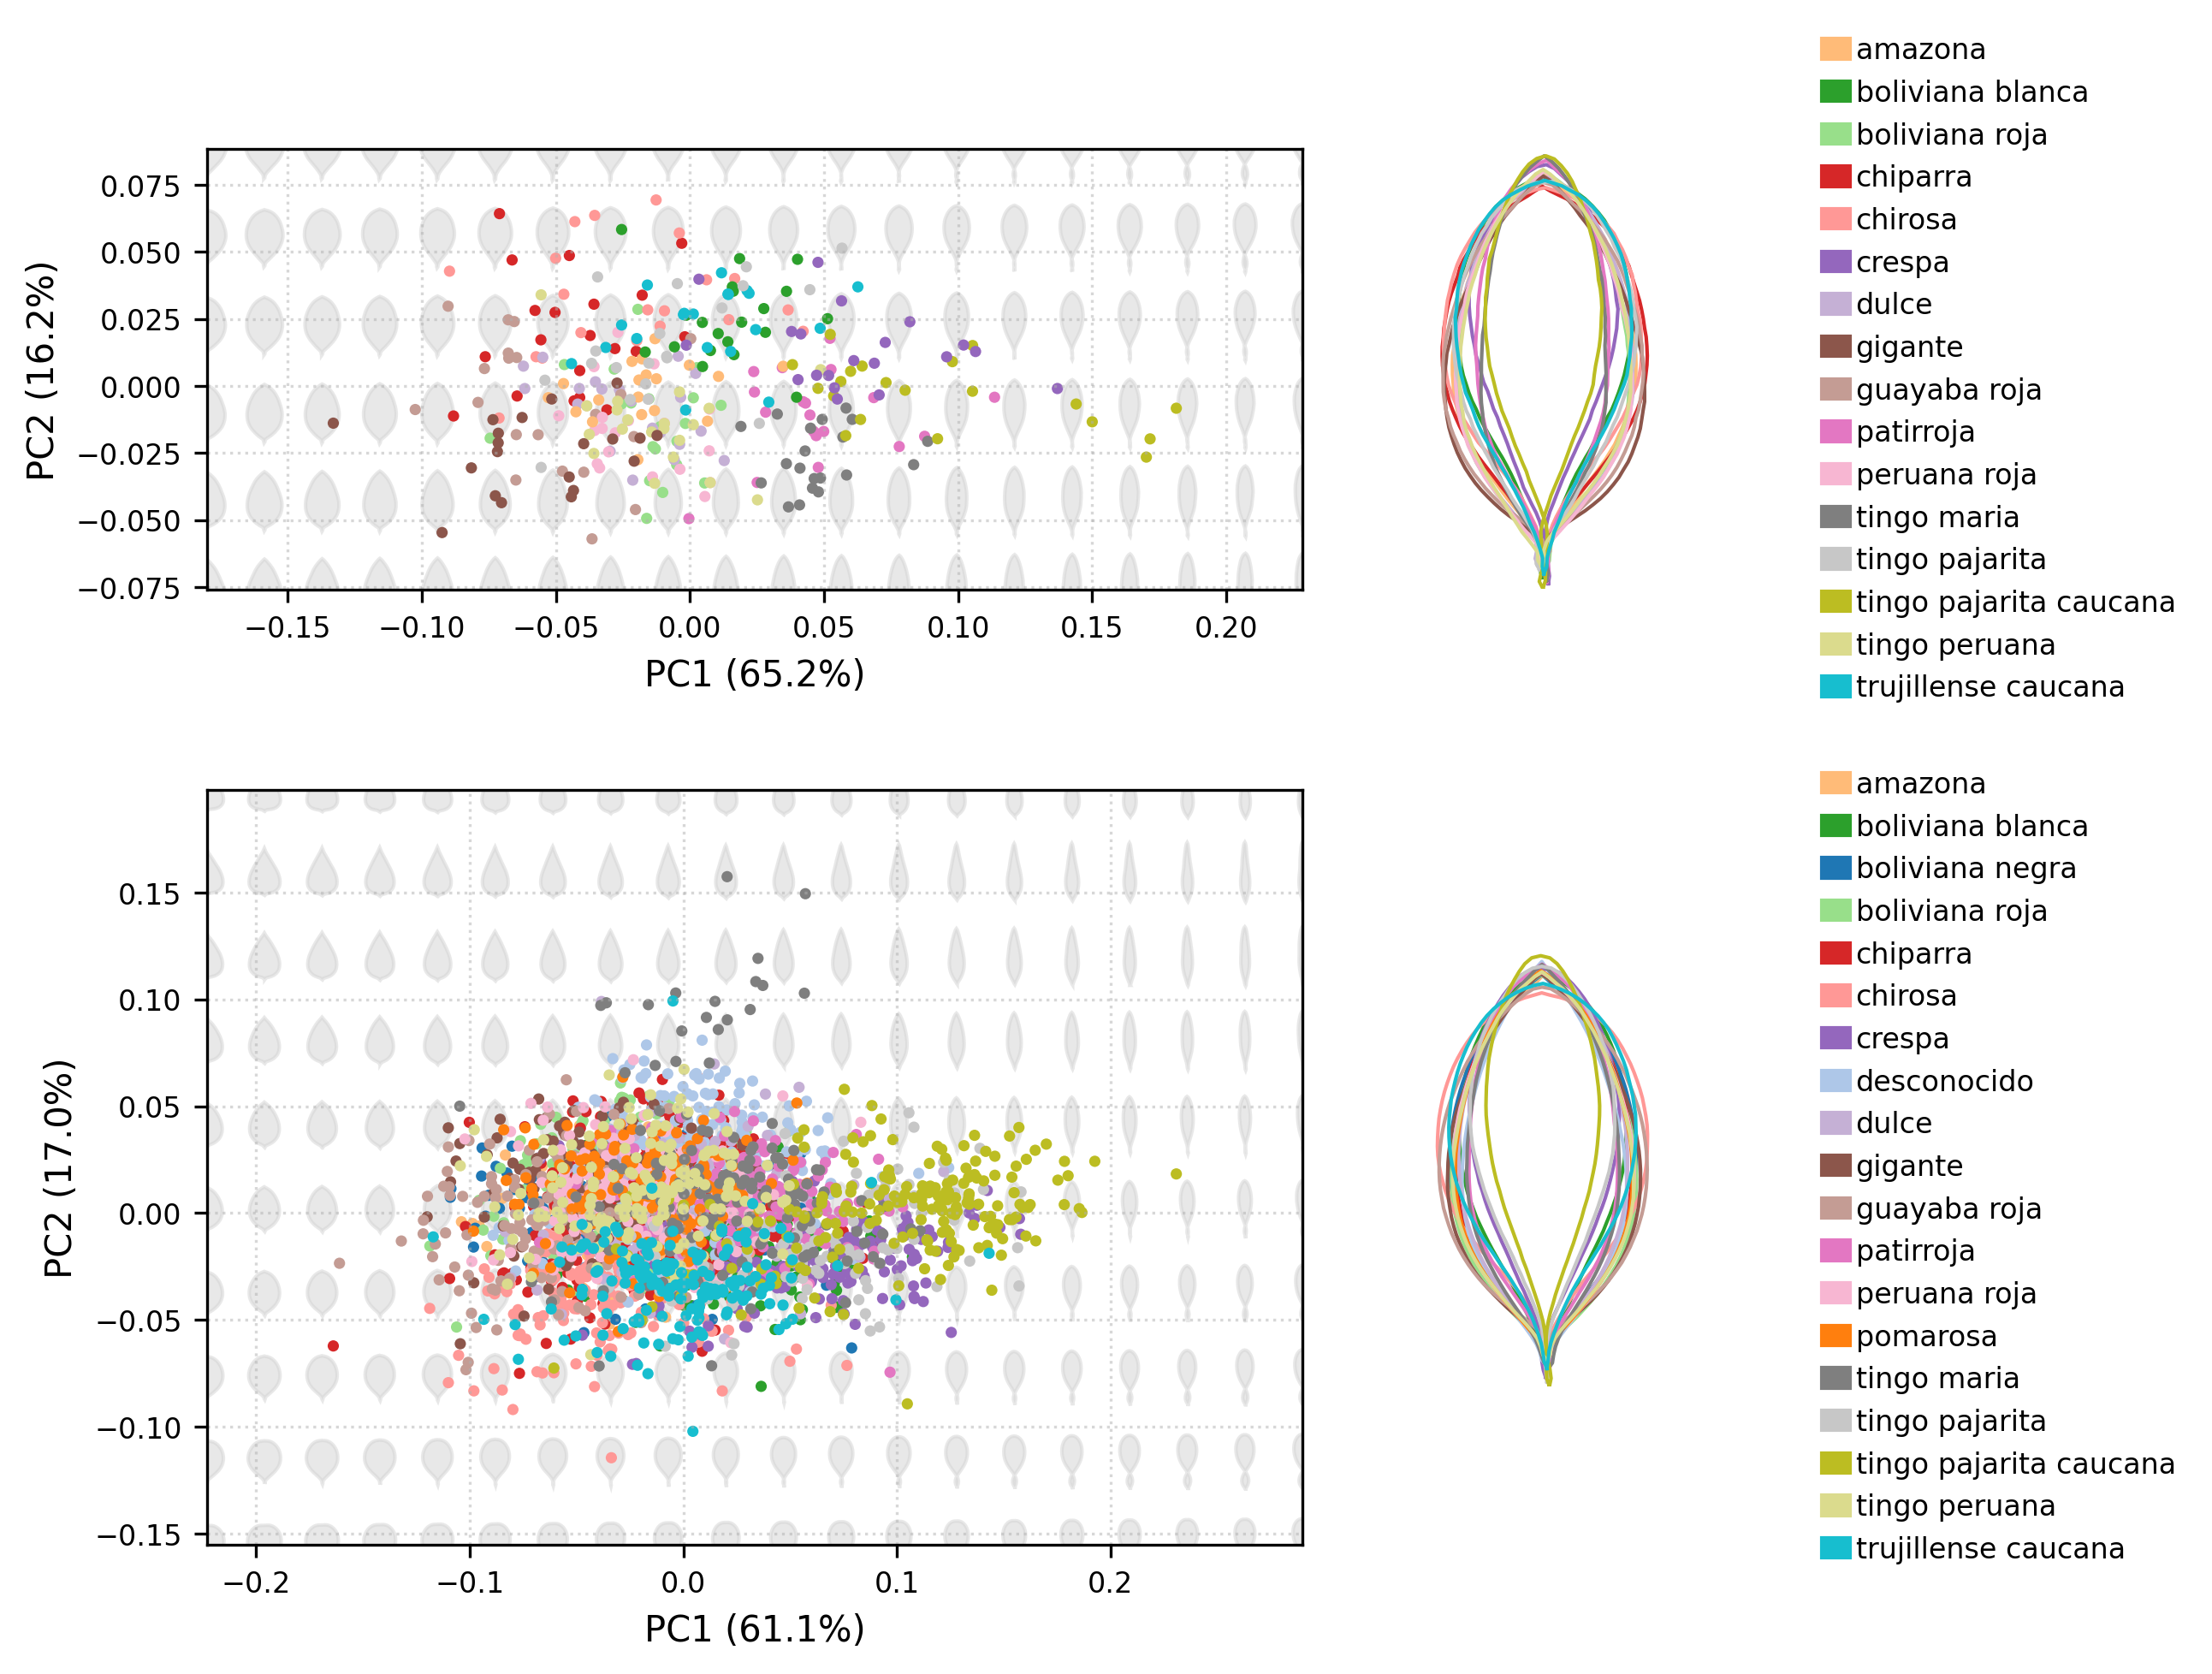

--- Figure Generation Complete ---


In [5]:
#######################
### LOAD IN MODULES ###
#######################

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import os
from sklearn.decomposition import PCA
from matplotlib.patches import Patch # For simplified legend patches

# Ensure consistent plotting style for publication
plt.style.use('seaborn-v0_8-deep')

############################
### GLOBAL CONFIGURATION ###
############################

# --- File Paths ---
# Base directory for data (relative to notebooks/)
DATA_BASE_DIR = "../data/CULTIVATED2ND/" # Points to COCA_PROJECT/data/CULTIVATED2ND/

# Morphometrics output subdirectories for the 16/19 cultigen datasets
MORPHOMETRICS_OUTPUT_SUBDIR_CULTIVATED1ST_16CULTIGENS = "03_morphometrics_output_cultivated1st_combined/"
MORPHOMETRICS_OUTPUT_SUBDIR_CULTIVATED2ND_19CULTIGENS = "03_morphometrics_output_cultivated2nd_combined/"

# Filenames for HDF5 outputs (specific to 16/19 cultigen data)
PCA_PARAMS_FILENAME_CULTIVATED1ST = "leaf_pca_model_parameters_cultivated1st.h5"
PCA_SCORES_LABELS_FILENAME_CULTIVATED1ST = "original_pca_scores_and_class_labels_cultivated1st.h5"

PCA_PARAMS_FILENAME_CULTIVATED2ND = "leaf_pca_model_parameters_cultivated2nd.h5"
PCA_SCORES_LABELS_FILENAME_CULTIVATED2ND = "original_pca_scores_and_class_labels_cultivated2nd.h5"


# Output directory for figures (relative to notebooks/)
FIGURES_OUTPUT_DIR = "../figures/" # Points to COCA_PROJECT/figures/
os.makedirs(FIGURES_OUTPUT_DIR, exist_ok=True) # Ensure directory exists

# --- Figure Parameters ---
PAGE_WIDTH_INCHES = 8.5
DPI = 300

NUM_MORPHOSPACES = 2 # Now only 2 rows for the morphospaces

# General font sizes
AXIS_LABEL_FONTSIZE = 10
AXIS_TICK_FONTSIZE = 8
LEGEND_FONTSIZE = 8 # Smaller for the narrow legend column

# --- Plotting Specifics for Morphospace ---
EIGENLEAF_SCALE_FACTOR = 0.08
EIGENLEAF_COLOR = "lightgray"
EIGENLEAF_ALPHA = 0.5
POINT_SIZE = 10
POINT_ALPHA = 1
POINT_LINEWIDTH = 0

# --- Mean Outlines Plotting ---
MEAN_OUTLINE_LINEWIDTH = 1.0
MEAN_OUTLINE_SCALE_FACTOR = 1.0
SHAPE_EXAGGERATION_FACTOR = 1.0

# NEW: Margin factor for plots to prevent clipping of points/eigenleaves
PLOT_MARGIN_FACTOR = 0.15

# Number of landmarks and dimensions (consistent for all datasets)
# Assuming these are still derived from the 99 landmarks * 2 dimensions
NUM_LANDMARKS = (50 * 2) - 1 # Assuming 99 landmarks as per previous calculations
NUM_DIMENSIONS = 2


# --- Global Class Lists and Color Palette ---

# Shared 16 cultigen names (alphabetical order as provided)
SHARED_16_CULTIGENS = [
    'amazona', 'boliviana blanca', 'boliviana roja', 'chiparra', 'chirosa',
    'crespa', 'dulce', 'gigante', 'guayaba roja', 'patirroja',
    'peruana roja', 'tingo maria', 'tingo pajarita', 'tingo pajarita caucana',
    'tingo peruana', 'trujillense caucana'
]

# Additional classes for the 2nd dataset, with their display names
ADDITIONAL_CULTIGENS_MAP = {
    "BON": "boliviana negra",
    "DES": "desconocido",
    "POM": "pomarosa"
}
ADDITIONAL_CULTIGENS_RAW_NAMES = list(ADDITIONAL_CULTIGENS_MAP.keys())
ADDITIONAL_CULTIGENS_DISPLAY_NAMES = list(ADDITIONAL_CULTIGENS_MAP.values())


# Combined list of all 19 unique classes for consistent color mapping
# Sort raw names to ensure the palette is consistently generated
ALL_19_CULTIGENS_RAW_ORDERED = sorted(SHARED_16_CULTIGENS + ADDITIONAL_CULTIGENS_RAW_NAMES)
# Sort display names for legend consistency
ALL_19_CULTIGENS_DISPLAY_ORDERED = sorted(SHARED_16_CULTIGENS + ADDITIONAL_CULTIGENS_DISPLAY_NAMES)


# Dynamically create a palette for all 19 classes using 'tab20' (good for ~20 distinct colors)
PALETTE = sns.color_palette('tab20', n_colors=len(ALL_19_CULTIGENS_RAW_ORDERED))
# Map raw class names to colors
CLASS_COLORS_MAP = {cls: PALETTE[i] for i, cls in enumerate(ALL_19_CULTIGENS_RAW_ORDERED)}

# Create a mapping from raw names to display names for labels
CLASS_DISPLAY_NAMES_MAP = {cls: cls for cls in SHARED_16_CULTIGENS}
CLASS_DISPLAY_NAMES_MAP.update(ADDITIONAL_CULTIGENS_MAP) # Add the remapped names


#########################
### HELPER FUNCTIONS ###
#########################

def load_morphometrics_data_from_h5(base_dir, morphometrics_subdir, pca_params_filename, pca_scores_labels_filename):
    """
    Loads PCA scores, class labels, original flattened coordinates,
    and PCA model parameters for a given dataset from HDF5 files,
    and calculates average shapes per class.
    """
    output_dir = os.path.join(base_dir, morphometrics_subdir)

    pca_scores_labels_path = os.path.join(output_dir, pca_scores_labels_filename)
    pca_params_path = os.path.join(output_dir, pca_params_filename)

    data = {}

    print(f"Loading data from {pca_scores_labels_path}")
    with h5py.File(pca_scores_labels_path, 'r') as f:
        data['pc_scores'] = f['pca_scores'][:]
        data['class_labels'] = f['class_labels'][:].astype(str)
        data['original_flattened_coords'] = f['original_flattened_coords'][:]

    print(f"Loading PCA parameters from {pca_params_path}")
    with h5py.File(pca_params_path, 'r') as f:
        data['pca_components'] = f['components'][:]
        data['pca_mean'] = f['mean'][:]
        data['pca_explained_variance_ratio'] = f['explained_variance_ratio'][:]
        data['num_pca_components'] = f.attrs['n_components']

    data['num_dimensions'] = NUM_DIMENSIONS # Use global constant
    data['num_landmarks'] = data['original_flattened_coords'].shape[1] // data['num_dimensions']

    # Calculate and store average shapes per class
    average_shapes = {}
    unique_classes = np.unique(data['class_labels'])
    for cls in unique_classes:
        class_indices = (data['class_labels'] == cls)
        class_coords_flat = data['original_flattened_coords'][class_indices]
        class_coords_3d = class_coords_flat.reshape(-1, data['num_landmarks'], data['num_dimensions'])
        avg_shape = np.mean(class_coords_3d, axis=0)
        average_shapes[cls] = avg_shape
    data['average_shapes_by_class'] = average_shapes

    print(f"Data loaded for {os.path.basename(morphometrics_subdir)}")
    return data

def plot_morphospace_panel(ax_main, data, class_colors_map, display_name_map,
                           pc1_intervals=20, pc2_intervals=6): # Added parameters here
    """
    Plots a single morphospace panel including scatter plot and eigenleaf grid.
    Uses class_colors_map and display_name_map for consistent plotting.
    Axis limits are determined independently for each panel.
    Allows independent control over eigenleaf intervals.
    """
    # Create a Series for plotting that maps raw labels to display labels for hue
    df_plot = pd.DataFrame({
        'PC1': data['pc_scores'][:, 0],
        'PC2': data['pc_scores'][:, 1],
        'Cultigen': [display_name_map.get(label, label) for label in data['class_labels']]
    })
    # Map raw class labels to their respective colors for seaborn (important for consistent palette)
    hue_order_raw = [label for label in ALL_19_CULTIGENS_RAW_ORDERED if label in data['class_labels']]
    plot_palette = {display_name_map.get(label, label): class_colors_map[label] for label in hue_order_raw}


    sns.scatterplot(
        data=df_plot, # IMPORTANT: Pass the DataFrame here
        x='PC1', y='PC2',
        hue='Cultigen',
        palette=plot_palette, # Use the mapped palette
        s=POINT_SIZE, linewidth=POINT_LINEWIDTH, alpha=POINT_ALPHA,
        ax=ax_main,
        legend=False # Legend handled by separate column
    )

    # Set axis limits based on data's own extent with a margin (independent axes)
    pc1_min_data, pc1_max_data = data['pc_scores'][:, 0].min(), data['pc_scores'][:, 0].max()
    pc2_min_data, pc2_max_data = data['pc_scores'][:, 1].min(), data['pc_scores'][:, 1].max()

    pc1_range = pc1_max_data - pc1_min_data
    pc2_range = pc2_max_data - pc2_min_data

    pc1_min_plot = pc1_min_data - pc1_range * PLOT_MARGIN_FACTOR
    pc1_max_plot = pc1_max_data + pc1_range * PLOT_MARGIN_FACTOR
    pc2_min_plot = pc2_min_data - pc2_range * PLOT_MARGIN_FACTOR
    pc2_max_plot = pc2_max_data + pc2_range * PLOT_MARGIN_FACTOR

    ax_main.set_xlim(pc1_min_plot, pc1_max_plot)
    ax_main.set_ylim(pc2_min_plot, pc2_max_plot)

    # Create PC intervals for plotting inverse eigenleaves based on *actual plotted limits*
    # Use passed parameters for intervals
    PC1_vals = np.linspace(pc1_min_plot, pc1_max_plot, pc1_intervals)
    PC2_vals = np.linspace(pc2_min_plot, pc2_max_plot, pc2_intervals)

    # Plot inverse eigenleaves (the background grid shapes)
    pca_components_2d = data['pca_components'][:2, :]
    pca_mean_flat = data['pca_mean']

    for i in PC1_vals:
        for j in PC2_vals:
            reconstructed_flat_shape = (np.array([i, j]) @ pca_components_2d) + pca_mean_flat
            reconstructed_shape_2d = reconstructed_flat_shape.reshape(data['num_landmarks'], data['num_dimensions'])
            ax_main.fill(reconstructed_shape_2d[:, 0] * EIGENLEAF_SCALE_FACTOR + i,
                         reconstructed_shape_2d[:, 1] * EIGENLEAF_SCALE_FACTOR + j,
                         color=EIGENLEAF_COLOR, alpha=EIGENLEAF_ALPHA, zorder=-1)

    # Set axis labels with explained variance from the first two PCs
    exp_var_pc1 = data['pca_explained_variance_ratio'][0] * 100
    exp_var_pc2 = data['pca_explained_variance_ratio'][1] * 100

    ax_main.set_xlabel(f"PC1 ({exp_var_pc1:.1f}%)", fontsize=AXIS_LABEL_FONTSIZE)
    ax_main.set_ylabel(f"PC2 ({exp_var_pc2:.1f}%)", fontsize=AXIS_LABEL_FONTSIZE)
    ax_main.tick_params(axis='x', labelsize=AXIS_TICK_FONTSIZE)
    ax_main.tick_params(axis='y', labelsize=AXIS_TICK_FONTSIZE)
    ax_main.set_aspect('equal', adjustable='box')
    ax_main.set_facecolor('white')
    ax_main.grid(True, linestyle=':', alpha=0.5)


def plot_mean_outlines(ax, data, class_colors_map, display_name_map):
    """
    Plots the mean leaf outline for each class in the dataset, with exaggeration.
    Uses class_colors_map and display_name_map for consistent plotting.
    """
    ax.clear()
    ax.set_axis_off()

    average_shapes = data['average_shapes_by_class']
    classes_in_data = np.unique(data['class_labels']) # Get unique classes actually present in this data

    if not average_shapes: # Handle case where no average shapes are present
        return

    overall_mean_shape_flat = data['pca_mean']
    overall_mean_shape_2d = overall_mean_shape_flat.reshape(data['num_landmarks'], data['num_dimensions'])

    exaggerated_shapes_to_plot = {} # Store exaggerated shapes temporarily

    # 1. Calculate all exaggerated shapes and find their max extent
    max_exaggerated_extent = 0
    for cls in classes_in_data:
        if cls in average_shapes: # Ensure the class has a defined average shape
            avg_shape_2d = average_shapes[cls]

            # Exaggerate the shape difference from the overall mean
            exaggerated_shape = avg_shape_2d + SHAPE_EXAGGERATION_FACTOR * (avg_shape_2d - overall_mean_shape_2d)

            # Center the exaggerated shape to calculate its extent for scaling
            centered_exaggerated_shape = exaggerated_shape - np.mean(exaggerated_shape, axis=0)
            max_exaggerated_extent = max(max_exaggerated_extent, np.max(np.abs(centered_exaggerated_shape)))

            exaggerated_shapes_to_plot[cls] = centered_exaggerated_shape # Store centered for plotting

    if max_exaggerated_extent == 0: max_exaggerated_extent = 1 # Avoid division by zero

    # 2. Plot the (now exaggerated and pre-centered) shapes
    # Sort classes by their display names for consistent plotting order
    sorted_classes_in_data = sorted(classes_in_data, key=lambda x: display_name_map.get(x, x))
    for cls in sorted_classes_in_data:
        if cls in exaggerated_shapes_to_plot: # Check if this class had an exaggerated shape generated
            centered_exaggerated_shape = exaggerated_shapes_to_plot[cls]
            color = class_colors_map.get(cls, 'black') # Get color using the raw class name

            # Scale the pre-centered shape based on the max extent found across ALL exaggerated shapes
            final_scaled_shape = (centered_exaggerated_shape / max_exaggerated_extent) * MEAN_OUTLINE_SCALE_FACTOR

            # Use ax.plot for outlines, with solid color and defined linewidth
            ax.plot(final_scaled_shape[:, 0], final_scaled_shape[:, 1],
                    color=color, linewidth=MEAN_OUTLINE_LINEWIDTH, zorder=2)

    # 3. Set fixed limits to display the scaled shapes (from -plot_limit to +plot_limit)
    plot_limit = 1.0 # Standard unit box for scaling
    ax.set_xlim(-plot_limit, plot_limit)
    ax.set_ylim(-plot_limit, plot_limit)
    ax.set_aspect('equal', adjustable='box')


def plot_color_legend(ax, class_list_raw, class_colors_map, display_name_map):
    """
    Creates a simple color-patch legend using raw class names to get colors
    and display_name_map for labels.
    """
    ax.clear()
    ax.set_axis_off()

    handles = []
    labels = []

    # Sort the class_list_raw by their display names for legend consistency
    sorted_class_list_raw = sorted(class_list_raw, key=lambda x: display_name_map.get(x, x))

    for cls_raw in sorted_class_list_raw:
        if cls_raw in class_colors_map:
            handles.append(Patch(color=class_colors_map[cls_raw]))
            labels.append(display_name_map.get(cls_raw, cls_raw)) # Use display name for label

    # Place the legend
    ax.legend(handles=handles, labels=labels, loc='center left',
              bbox_to_anchor=(0.05, 0.5),
              frameon=False, fontsize=LEGEND_FONTSIZE, handlelength=1.0, handletextpad=0.2, columnspacing=0.5)


##########################
### MAIN FIGURE SCRIPT ###
##########################

print("--- Starting Figure Generation for 16/19 Cultigens ---")

# 1. Load Data for Cultivated1st (16 Cultigens)
print("\nLoading Cultivated1st (16 Cultigens) data...")
cultivated1st_16cultigens_data = load_morphometrics_data_from_h5(
    DATA_BASE_DIR,
    MORPHOMETRICS_OUTPUT_SUBDIR_CULTIVATED1ST_16CULTIGENS,
    PCA_PARAMS_FILENAME_CULTIVATED1ST,
    PCA_SCORES_LABELS_FILENAME_CULTIVATED1ST
)

# 2. Load Data for Cultivated2nd (19 Cultigens)
print("\nLoading Cultivated2nd (19 Cultigens) data...")
cultivated2nd_19cultigens_data = load_morphometrics_data_from_h5(
    DATA_BASE_DIR,
    MORPHOMETRICS_OUTPUT_SUBDIR_CULTIVATED2ND_19CULTIGENS,
    PCA_PARAMS_FILENAME_CULTIVATED2ND,
    PCA_SCORES_LABELS_FILENAME_CULTIVATED2ND
)

# --- Dynamically adjust panel height to match data aspect ratio ---
# Calculate separate data aspect ratios for each dataset
data_aspect_ratio_1st = (cultivated1st_16cultigens_data['pc_scores'][:, 0].max() - cultivated1st_16cultigens_data['pc_scores'][:, 0].min()) / \
                        (cultivated1st_16cultigens_data['pc_scores'][:, 1].max() - cultivated1st_16cultigens_data['pc_scores'][:, 1].min())

data_aspect_ratio_2nd = (cultivated2nd_19cultigens_data['pc_scores'][:, 0].max() - cultivated2nd_19cultigens_data['pc_scores'][:, 0].min()) / \
                        (cultivated2nd_19cultigens_data['pc_scores'][:, 1].max() - cultivated2nd_19cultigens_data['pc_scores'][:, 1].min())

# Define column width ratios as discussed: Main (5), Outlines (2), Legend (1)
COL_MAIN_MORPHOSPACE_RATIO = 5
COL_MEAN_OUTLINES_RATIO = 2
COL_SIMPLE_LEGEND_RATIO = 1
TOTAL_COL_RATIO = COL_MAIN_MORPHOSPACE_RATIO + COL_MEAN_OUTLINES_RATIO + COL_SIMPLE_LEGEND_RATIO

MAIN_PLOT_EFFECTIVE_WIDTH_RATIO = COL_MAIN_MORPHOSPACE_RATIO / TOTAL_COL_RATIO

# Calculate height for each morphospace panel independently
HEIGHT_PER_MORPHOSPACE_PANEL_1ST_INCHES = (MAIN_PLOT_EFFECTIVE_WIDTH_RATIO * PAGE_WIDTH_INCHES) / data_aspect_ratio_1st
HEIGHT_PER_MORPHOSPACE_PANEL_2ND_INCHES = (MAIN_PLOT_EFFECTIVE_WIDTH_RATIO * PAGE_WIDTH_INCHES) / data_aspect_ratio_2nd

TOTAL_VERTICAL_PADDING_INCHES = (0.35 * NUM_MORPHOSPACES) # Roughly for inter-row space and labels.
FIGURE_HEIGHT_INCHES = HEIGHT_PER_MORPHOSPACE_PANEL_1ST_INCHES + HEIGHT_PER_MORPHOSPACE_PANEL_2ND_INCHES + TOTAL_VERTICAL_PADDING_INCHES

print(f"Dynamically calculated HEIGHT_PER_MORPHOSPACE_PANEL_1ST_INCHES: {HEIGHT_PER_MORPHOSPACE_PANEL_1ST_INCHES:.2f} inches")
print(f"Dynamically calculated HEIGHT_PER_MORPHOSPACE_PANEL_2ND_INCHES: {HEIGHT_PER_MORPHOSPACE_PANEL_2ND_INCHES:.2f} inches")
print(f"Resulting FIGURE_HEIGHT_INCHES (with padding): {FIGURE_HEIGHT_INCHES:.2f} inches")


# 3. Define Figure Layout using GridSpec (2 rows, 3 columns)
fig = plt.figure(figsize=(PAGE_WIDTH_INCHES, FIGURE_HEIGHT_INCHES), dpi=DPI,
                 constrained_layout=True)

fig.set_constrained_layout_pads(w_pad=0.04, h_pad=0.08, wspace=0.03, hspace=0.05)

gs = fig.add_gridspec(
    nrows=NUM_MORPHOSPACES, ncols=3,
    height_ratios=[HEIGHT_PER_MORPHOSPACE_PANEL_1ST_INCHES, HEIGHT_PER_MORPHOSPACE_PANEL_2ND_INCHES],
    width_ratios=[COL_MAIN_MORPHOSPACE_RATIO, COL_MEAN_OUTLINES_RATIO, COL_SIMPLE_LEGEND_RATIO]
)

# 4. Plot Cultivated1st (16 Cultigens) Row (Morphospace, Mean Outlines, Legend)
print("\nPlotting Cultivated1st (16 Cultigens) row...")
ax_cultivated1st_main = fig.add_subplot(gs[0, 0])
# Default intervals for the first plot
plot_morphospace_panel(ax_cultivated1st_main, cultivated1st_16cultigens_data,
                       class_colors_map=CLASS_COLORS_MAP,
                       display_name_map=CLASS_DISPLAY_NAMES_MAP,
                       pc1_intervals=20, pc2_intervals=6) # Explicitly set for clarity

ax_cultivated1st_outlines = fig.add_subplot(gs[0, 1])
plot_mean_outlines(ax_cultivated1st_outlines, cultivated1st_16cultigens_data,
                   CLASS_COLORS_MAP, CLASS_DISPLAY_NAMES_MAP)

ax_cultivated1st_legend = fig.add_subplot(gs[0, 2])
plot_color_legend(ax_cultivated1st_legend, SHARED_16_CULTIGENS, # Only show 16 in legend for this panel
                  CLASS_COLORS_MAP, CLASS_DISPLAY_NAMES_MAP)


# 5. Plot Cultivated2nd (19 Cultigens) Row (Morphospace, Mean Outlines, Legend)
print("Plotting Cultivated2nd (19 Cultigens) row...")
ax_cultivated2nd_main = fig.add_subplot(gs[1, 0])
# Increase pc2_intervals for the second plot
plot_morphospace_panel(ax_cultivated2nd_main, cultivated2nd_19cultigens_data,
                       class_colors_map=CLASS_COLORS_MAP,
                       display_name_map=CLASS_DISPLAY_NAMES_MAP,
                       pc1_intervals=20, pc2_intervals=10) # Increased PC2 intervals to 10

ax_cultivated2nd_outlines = fig.add_subplot(gs[1, 1])
# For plotting mean outlines, we need to pass all 19 raw class names present in this dataset
all_19_cultigens_for_outlines = SHARED_16_CULTIGENS + ADDITIONAL_CULTIGENS_RAW_NAMES
plot_mean_outlines(ax_cultivated2nd_outlines, cultivated2nd_19cultigens_data,
                   CLASS_COLORS_MAP, CLASS_DISPLAY_NAMES_MAP)

ax_cultivated2nd_legend = fig.add_subplot(gs[1, 2])
plot_color_legend(ax_cultivated2nd_legend, ALL_19_CULTIGENS_RAW_ORDERED, # Show all 19 in legend for this panel
                  CLASS_COLORS_MAP, CLASS_DISPLAY_NAMES_MAP)


# 6. Final Adjustments and Saving
output_filename = "Cultivated_16_19_Cultigens_Morphospaces_IndependentAxes_CustomEigenleaf.png" # Changed filename
plt.savefig(os.path.join(FIGURES_OUTPUT_DIR, output_filename), dpi=DPI, bbox_inches='tight')
print(f"\nFigure saved to: {os.path.join(FIGURES_OUTPUT_DIR, output_filename)}")

plt.show()
print("--- Figure Generation Complete ---")